### 0. Import libraries

In [209]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/adult-census-income/adult.csv


In [210]:
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (9, 9)
warnings.filterwarnings("ignore")

### 1. Load data

In [211]:
df = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [212]:
df.shape

(32561, 15)

In [213]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

### 2. Data wrangling

#### 2.1) Missing Values

In our data, we can observe missing values encoded with the sign **"?"**. Replace them with **np.nan**

In [214]:
df.replace({"?": np.nan}, inplace = True)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Let's count the number of missing values:

In [215]:
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

Find the percentage ratio:

In [216]:
df_isna = df.isna().sum() * 100 / len(df)
df_isna = df_isna.round(2)
df_isna

age               0.00
workclass         5.64
fnlwgt            0.00
education         0.00
education.num     0.00
marital.status    0.00
occupation        5.66
relationship      0.00
race              0.00
sex               0.00
capital.gain      0.00
capital.loss      0.00
hours.per.week    0.00
native.country    1.79
income            0.00
dtype: float64

Let's create a **heat map of the missing values** for clarity:

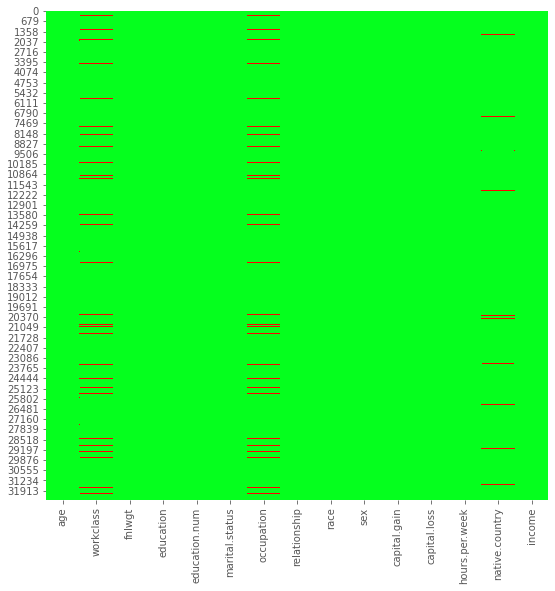

In [217]:
colors = ["#05ff1e", '#ff0000']
sns.heatmap(df.isna(), cbar = False, cmap = colors);

Let's look at the type of columns with missing values:

In [218]:
df[["workclass", "occupation", "native.country"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       30725 non-null  object
 1   occupation      30718 non-null  object
 2   native.country  31978 non-null  object
dtypes: object(3)
memory usage: 763.3+ KB


Replace the missing categorical values most frequent value:

In [219]:
def impute_nan(dataframe, column_name):
    frequent_value = dataframe[column_name].mode()[0]
    dataframe[column_name] = dataframe[column_name].fillna(frequent_value)

In [220]:
for column in ["workclass", "occupation", "native.country"]:
    impute_nan(df, column)

In [221]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

#### 2.2) Outliers

Let's see if there are **outliers** in our data:

In [222]:
df_float = df.select_dtypes(include = [np.number])
df_float.columns

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object')

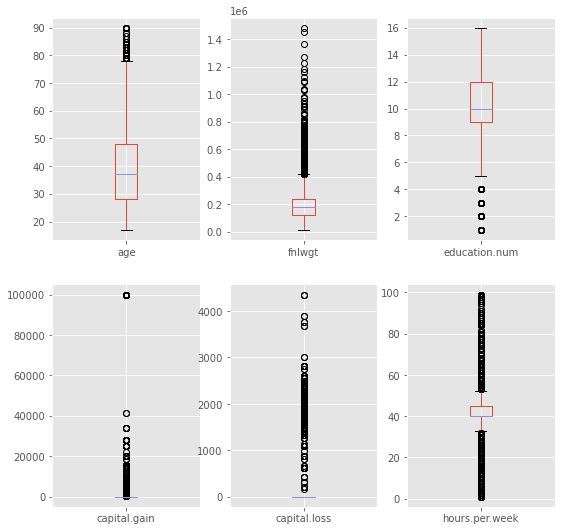

In [223]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (9, 9))

df.boxplot(column = "age", ax = axes[0, 0]);
df.boxplot(column = "fnlwgt", ax = axes[0, 1]);
df.boxplot(column = "education.num", ax = axes[0, 2]);
df.boxplot(column = "capital.gain", ax = axes[1, 0]);
df.boxplot(column = "capital.loss", ax = axes[1, 1]);
df.boxplot(column = "hours.per.week", ax = axes[1, 2]);

Remove values that deviate by 3 standard deviations:

In [224]:
z_score = np.abs(stats.zscore(df_float))
df = df[(z_score < 3).all(axis = 1)]

In [225]:
df.reset_index(inplace = True)
df.drop("index", axis = 1, inplace = True)

#### 2.3) Working with columns and values

In [226]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,62,Local-gov,159908,Bachelors,13,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,1258,38,United-States,<=50K
1,72,Local-gov,144515,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1258,40,United-States,<=50K
2,76,Private,224680,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1258,20,United-States,<=50K
3,66,Private,350498,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,1258,20,United-States,<=50K
4,33,Local-gov,262042,HS-grad,9,Divorced,Adm-clerical,Own-child,White,Female,0,1138,40,United-States,<=50K


Edit the columns:

In [230]:
df.columns = ["age", "workclass", "final_weight", "education", "education_num", "martial_status",
             "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
             "hours_per_week", "native_country", "income"]

We will reduce all columns with strings to lowercase:

In [231]:
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].str.lower()
        
df.head()

,age,workclass,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,62,local-gov,159908,bachelors,13,married-civ-spouse,adm-clerical,wife,white,female,0,1258,38,united-states,<=50k
1,72,local-gov,144515,doctorate,16,married-civ-spouse,exec-managerial,husband,white,male,0,1258,40,united-states,<=50k
2,76,private,224680,prof-school,15,married-civ-spouse,prof-specialty,husband,white,male,0,1258,20,united-states,<=50k
3,66,private,350498,some-college,10,married-civ-spouse,transport-moving,husband,white,male,0,1258,20,united-states,<=50k
4,33,local-gov,262042,hs-grad,9,divorced,adm-clerical,own-child,white,female,0,1138,40,united-states,<=50k


### 3. Exploratory data analysis (EDA)

Columns:

1. **age** - the age of an individual
2. **workclass** - a general term to represent the employment status of an individual
3. **final weight** -  in other words, this is the number of people the census believes the entry represents
4. **education** - the highest level of education achieved by an individual
5. **education_num** - the highest level of education achieved in numerical form.
6. **marital_status** - marital status of an individual. Married civ spouse corresponds to a civilian spouse while Married AF spouse is a spouse in the Armed Forces
7. **occupation** - the general type of occupation of an individual
8. **relationship** - represents what this individual is relative to others
9. **race** - descriptions of an individual’s race
10. **sex** - the biological sex of the individual
11. **capital_gain** - capital gains for an individual
12. **capital_loss** - capital loss for an individual
13. **hours_per_week**  -  the hours an individual has reported to work per week continuous
14. **income** - whether or not an individual makes more than 50,000 dollars annually (the label)

P.S. The description of the columns was taken from this file: <a href = "http://cseweb.ucsd.edu/classes/sp15/cse190-c/reports/sp15/048.pdf">click</a>

#### 3.1) Descriptive statistics

In [232]:
df.describe()

,age,final_weight,education_num,capital_gain,capital_loss,hours_per_week
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.000000,29828.000000
mean,38.143758,185192.521590,10.077980,570.217212,1.209367,39.896104
std,13.357445,94546.882879,2.452859,2332.536197,32.711554,11.139495
min,17.000000,12285.000000,3.000000,0.000000,0.000000,4.000000
25%,27.000000,117508.500000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,177667.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,234279.250000,12.000000,0.000000,0.000000,45.000000
max,79.000000,506329.000000,16.000000,22040.000000,1258.000000,77.000000


In [237]:
df.select_dtypes(exclude = [np.number]).columns

Index(['workclass', 'education', 'martial_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')

Value_counts for **workclass**:

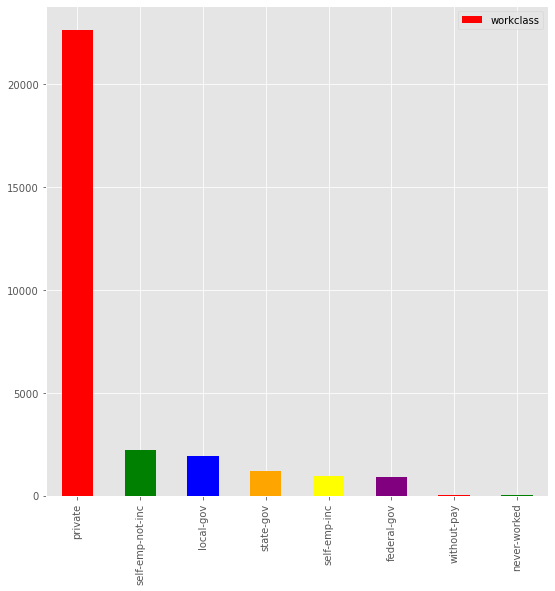

In [240]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["workclass"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **education**:

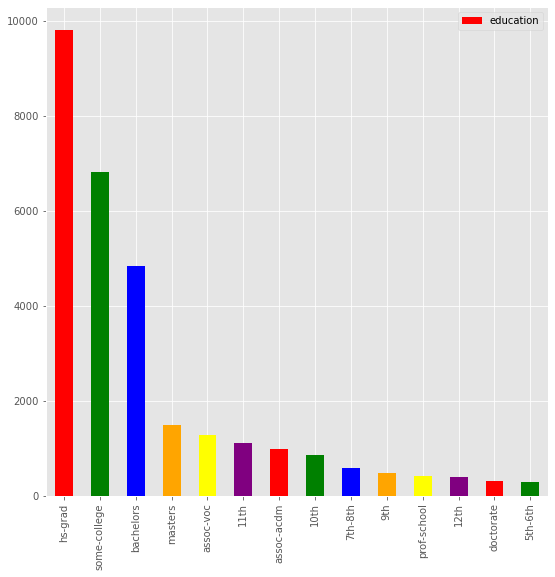

In [241]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["education"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **martial_status**:

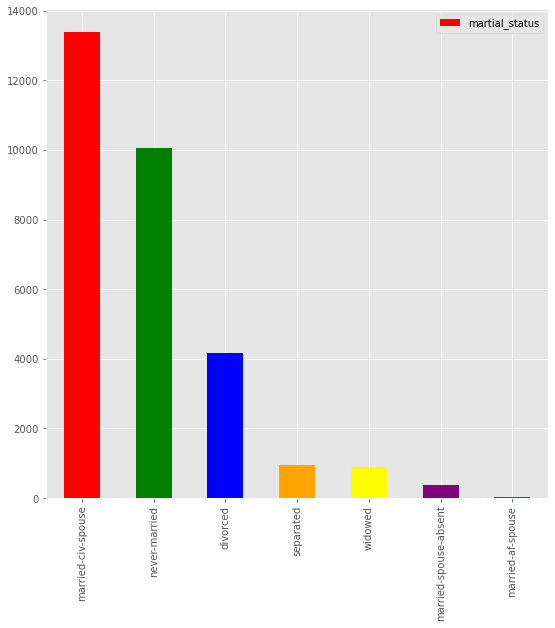

In [242]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["martial_status"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **occupations**:

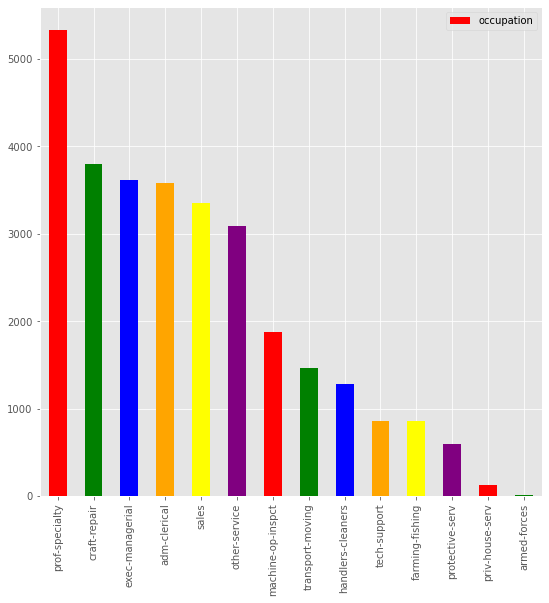

In [244]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["occupation"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **race**:

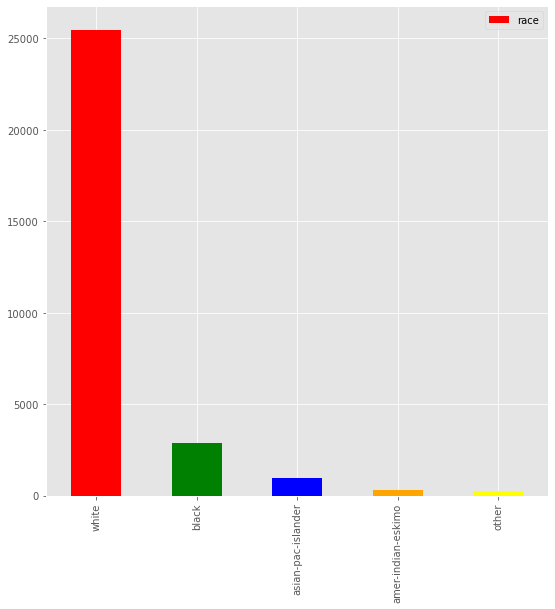

In [245]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["race"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **sex**:

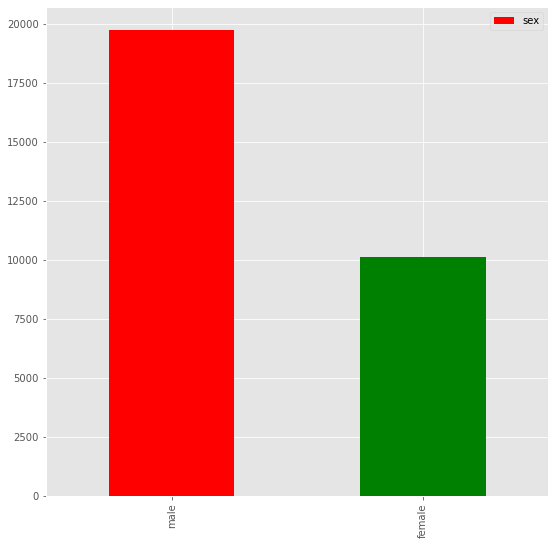

In [246]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["sex"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

Value_counts for **native_country**:

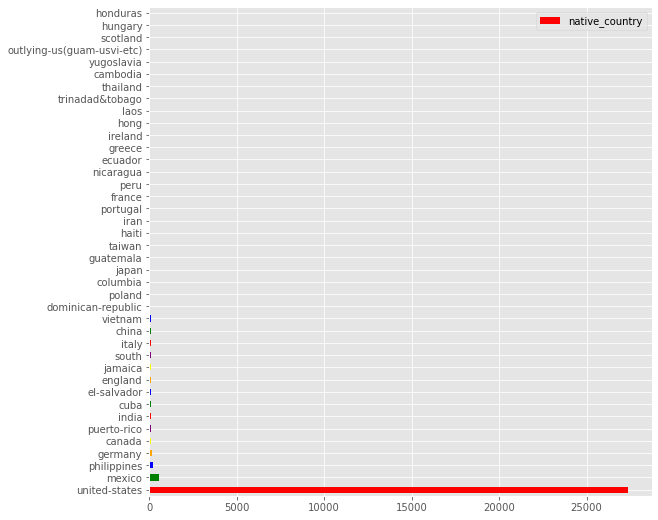

In [248]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["native_country"].value_counts().plot.barh(color = colors, legend = True);
plt.legend();

Value_counts for **income**:

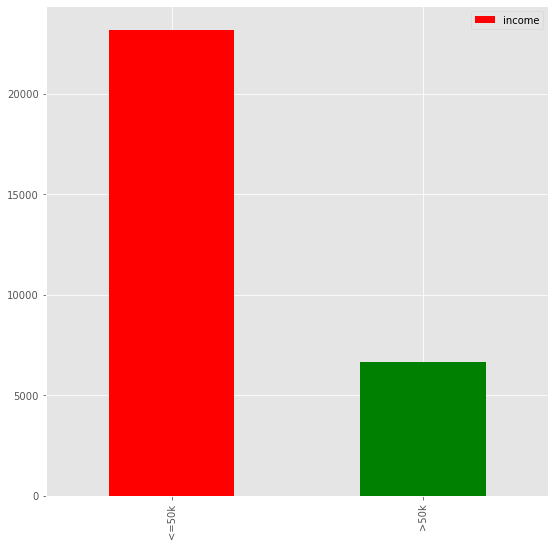

In [250]:
colors = ["red", "green", "blue", "orange", "yellow", "purple"]
df["income"].value_counts().plot.bar(color = colors, legend = True);
plt.legend();

In [251]:
df["income"].value_counts() * 100 / len(df)

<=50k    77.692101
>50k     22.307899
Name: income, dtype: float64

#### 3.2) GroupBy

In [252]:
df.head()

,age,workclass,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,62,local-gov,159908,bachelors,13,married-civ-spouse,adm-clerical,wife,white,female,0,1258,38,united-states,<=50k
1,72,local-gov,144515,doctorate,16,married-civ-spouse,exec-managerial,husband,white,male,0,1258,40,united-states,<=50k
2,76,private,224680,prof-school,15,married-civ-spouse,prof-specialty,husband,white,male,0,1258,20,united-states,<=50k
3,66,private,350498,some-college,10,married-civ-spouse,transport-moving,husband,white,male,0,1258,20,united-states,<=50k
4,33,local-gov,262042,hs-grad,9,divorced,adm-clerical,own-child,white,female,0,1138,40,united-states,<=50k


In [259]:
df.groupby("workclass")["age"].agg(["count", "mean"])

,count,mean
workclass,,
federal-gov,885,42.550282
local-gov,1915,41.497128
never-worked,7,20.571429
private,22639,36.711869
self-emp-inc,938,45.535181
self-emp-not-inc,2213,44.460009
state-gov,1217,39.106820
without-pay,14,47.785714
